#Pytorch walkthrough

here we call ```torch.device``` to see if gpu is available

In [1]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download MNIST dataset

MNIST stands for  (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. \\
The MNIST database contains 60,000 training images and 10,000 testing images. \\
Each image has the dimension of 28 by 28 pixels. \\
PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST, MNIST etc…) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model.

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


# Visualization of the dataset

In [4]:
images, label = train_data[0]
print(images.shape)

torch.Size([1, 28, 28])


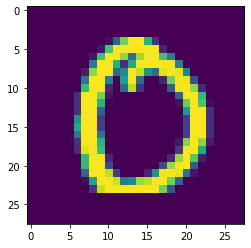

In [5]:
import matplotlib.pyplot as plt
images, label = train_data[88]
plt.imshow(images.reshape(28,28))

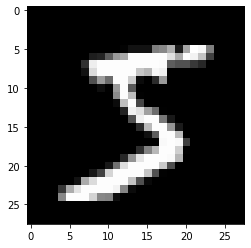

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.show()

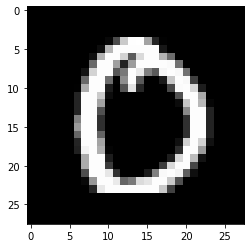

In [7]:
plt.imshow(images.squeeze(), cmap="gray")

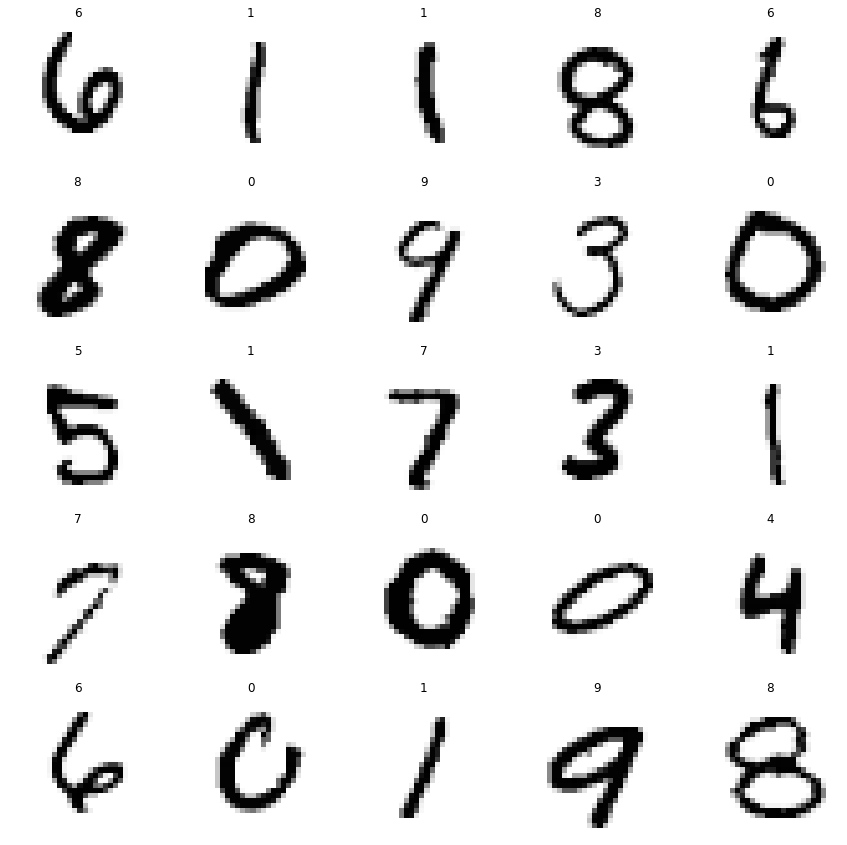

In [8]:
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="Greys")
plt.show()

# Preparing data for training with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.
DataLoader is an iterable that abstracts this complexity for us in an easy API

In [9]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=2),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=1000,
                                          shuffle=False, 
                                          num_workers=2),
}


# Define the Network model



```in_channels``` (int) — Number of channels in the input image \\
```out_channels``` (int) — Number of channels produced by the convolution \\
```kernel_size``` (int or tuple) — Size of the convolving kernel \\
```stride``` (int or tuple, optional) — Stride of the convolution. Default: 1 \\
```padding``` (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0 \\
```padding_mode``` (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’ \\
```bias``` (bool, optional) — If True, adds a learnable bias to the output. Default: True \\

```in_channels```=1: because our input is a grayscale image. \\
```Stride```: is the number of pixels to pass at a time when sliding the convolutional kernel. \\
```Padding```: to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image. \\
```kernel_size```: we need to define a kernel which is a small matrix of size 5 * 5. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image. \\
The ```forward()``` pass defines the way we compute our output using the given layers and functions. \\

In [10]:
import torch.nn.functional as F
class Fully_connected(torch.nn.Module):
  def __init__(self):
    super(Fully_connected, self).__init__()
    #=====================================
    self.l1 = nn.Linear(784, 128, bias=False)  # input* layer1 28*28
    self.l2 = nn.Linear(128, 10, bias=False)
    #======================================
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    #===================
    x = self.l1(x)
    x = F.relu(x)
    x = self.l2(x)
    #===================
    x = self.sm(x)
    return x


In [11]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2,),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),)
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output   

def test():
  batch_size = 5
  test_x = torch.rand((batch_size,1,28,28))
  model = CNN()
  out  = model(test_x)
  print(out.shape)
test()

torch.Size([5, 10])


In [12]:
cnn = CNN().to(device)
fc = Fully_connected().to(device)

In [13]:
from torch import optim
loss_func = nn.CrossEntropyLoss()
#loss_func = nn.MSELoss()
optimizer_cnn = optim.Adam(cnn.parameters(), lr = 0.0002) 
optimizer_fc = optim.Adam(fc.parameters(),lr = 0.0002)
print(optimizer_cnn)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)


Create a function called train() and pass num of epochs, model and data loaders as input parameters.
num_epochs: Number of times our model will go through the entire training dataset

In [14]:
def train(num_epochs, model, loaders,optimizer):
    loss_history = []
    train_accuracy = []
    model.train()
    # Train the model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            images = images.to(device).reshape(-1, 28*28).float()
            labels = labels.to(device)

            output = model(images)              
            loss = loss_func(output,labels)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()
            
            out = torch.argmax(output, dim=1)
            accuracy = (out == labels).float().mean()

            #append the result into a list for plotting later
            loss_history.append(loss)
            train_accuracy.append(accuracy.item())

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, train Accuracy : {accuracy}' )
    
    return loss_history,train_accuracy

In [15]:
num_epochs = 5
loss_history,train_accuracy = train(num_epochs, fc, loaders,optimizer_fc)

Epoch [1/5], Loss: 1.1887, train Accuracy : 0.8199999928474426
Epoch [1/5], Loss: 0.6792, train Accuracy : 0.8499999642372131
Epoch [1/5], Loss: 0.5740, train Accuracy : 0.85999995470047
Epoch [1/5], Loss: 0.5435, train Accuracy : 0.8299999833106995
Epoch [1/5], Loss: 0.5165, train Accuracy : 0.8700000047683716
Epoch [1/5], Loss: 0.4089, train Accuracy : 0.8799999952316284
Epoch [2/5], Loss: 0.4171, train Accuracy : 0.8899999856948853
Epoch [2/5], Loss: 0.3123, train Accuracy : 0.8999999761581421
Epoch [2/5], Loss: 0.2663, train Accuracy : 0.9399999976158142
Epoch [2/5], Loss: 0.2101, train Accuracy : 0.949999988079071
Epoch [2/5], Loss: 0.3753, train Accuracy : 0.8700000047683716
Epoch [2/5], Loss: 0.2411, train Accuracy : 0.9199999570846558
Epoch [3/5], Loss: 0.3676, train Accuracy : 0.8999999761581421
Epoch [3/5], Loss: 0.1709, train Accuracy : 0.9399999976158142
Epoch [3/5], Loss: 0.1936, train Accuracy : 0.949999988079071
Epoch [3/5], Loss: 0.2702, train Accuracy : 0.9399999976158

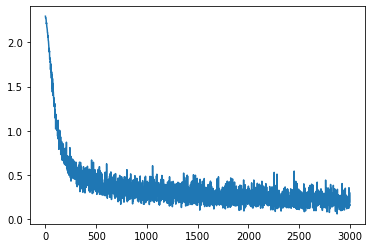

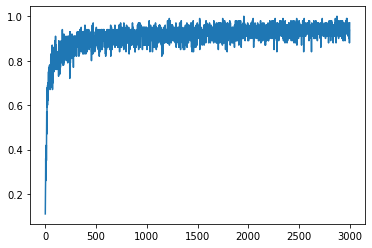

In [16]:
#plot
plt.plot(loss_history)
plt.show()
plt.plot(train_accuracy)
plt.show()

# Evaluate the model

We must call ```model.eval()``` to set dropout and batch normalization layers to evaluation mode before running inference.
```model.train()``` tells your model that you are training the model. So effectively layers like ```dropout```, ```batchnorm``` etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.
You can call either ```model.eval()``` or ```model.train(mode=False)``` to tell that you are testing the model.

In [17]:
def test(model):
    # Test the model
    test_model = model
    test_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device).reshape(-1, 28*28).float()
            labels =labels.to(device)
            test_output= test_model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print(f'Test Accuracy of the model on the 10000 test images: {accuracy*100} %')

In [18]:
test(model=fc)

Test Accuracy of the model on the 10000 test images: 94.1 %


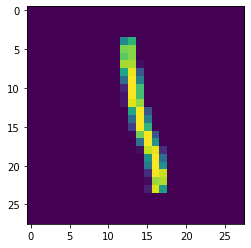

our model predict the number is 1


In [19]:
#============ try it yourself ===========
#entery number between 0 and 9999
test_number= test_data.data[189]
#========================================

plt.imshow(test_number)
plt.show()
our_model_prediction = fc(test_number.reshape(-1,784).float().to(device))
prediction = torch.max(our_model_prediction, 1)[1].data.cpu().numpy().squeeze()
print(f'our model predict the number is {prediction}')

In [20]:
#==============batch testing ===============

batch_size = 10
starting_point = 250

sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[starting_point:starting_point+batch_size].numpy()
test_imgs = test_data.data[starting_point:starting_point+batch_size].reshape(batch_size,1,28,28).float()
test_imgs = test_imgs.to(device)

test_output= fc(test_imgs.reshape(-1,28*28))
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
print(f'Prediction number: {pred_y}')
sample = next(iter(loaders['test']))
print(f'Actual number:     {actual_number}')

Prediction number: [4 1 9 5 7 7 2 8 2 0]
Actual number:     [4 1 9 5 7 7 2 8 2 6]


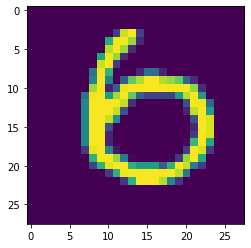

In [21]:
wrong_number = test_data.data[259]
plt.imshow(wrong_number)